# Import variables

参考

https://disassemble-channel.com/lstm-multivariate-time-series/

In [136]:
template1=(8, 5) # figサイズのテンプレート

exDataIsAll=True  
# exDataIsAll=False

epochs=15

In [137]:
import datetime
import os
# 実行ごとにディレクトリを作成
start_time = datetime.datetime.now()
dir_str = start_time.strftime('%Y%m%d-%H%M%S')   #20240914-193000
directory = f'./pickles/{dir_str}/'

# ディレクトリが存在しない場合は作成
os.makedirs(directory, exist_ok=True)

## Date

In [138]:
# 訓練期間とテスト期間を日付で指定
train_start_date    = '2016-01-01 00:00:00'
train_end_date      = '2022-12-31 23:59:59'
test_start_date     = '2023-01-01 00:00:00'
test_end_date       = '2023-12-31 23:59:59'


# train_start_date    = '2018-04-01 00:00:00'
# train_end_date      = '2018-06-30 23:59:59'
# test_start_date     = '2018-07-01 00:00:00'
# test_end_date       = '2018-07-11 23:59:59'

In [139]:
### 日付加工：外部変数を読みたるため
split_date = test_start_date

date_st = train_start_date[0:4]+train_start_date[5:7]+train_start_date[8:10]+train_start_date[11:13]+train_start_date[14:16]
date_en = test_end_date[0:4]+test_end_date[5:7]+test_end_date[8:10]+test_end_date[11:13]+test_end_date[14:16]

print(train_start_date,'\t→\t',test_end_date)
print(date_st,'\t\t→\t',date_en)

2016-01-01 00:00:00 	→	 2023-12-31 23:59:59
201601010000 		→	 202312312359


## Mesh ID

In [140]:
# import pandas as pd
# PATH_mesh = '../csv_data/meshID/ID_Kurashiki_Mabicho_shelter.csv'
# df = pd.read_csv(PATH_mesh)
# print(df.head())

# # KEY_CODEを追加していく
# areas = []
# for area in df['KEY_CODE']:
#     # print(area)
#     areas.append(area)

# print()
# # print(f'{len(areas)} areas in total：{areas}')

# # SQLで送信するようにデータを加工
# areas_str=''
# for k in areas:
#     areas_str+=(str(k)+',')
# areas_str=areas_str[:-1]  #最後の一文字に余分なカンマが入っているのでその部分を除いて変数を更新
# areas_list = areas_str.split(',')

# print(f'{len(areas_list)} areas in total: {areas_list}')


## Import Population data

In [141]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt

#　print用の名前をつけているだけ
name_trainPeriod='    Train(\t'+train_start_date[0:10]+'\t→\t'+train_end_date[0:10]+')'
print(name_trainPeriod)
name_testPeriod='    Test(\t'+test_start_date[0:10]+'\t→\t'+test_end_date[0:10]+')'
print(name_testPeriod)



# データベースの接続情報
connection_config = {
    'user': 'shin',
    'password': 'shin_password',
    'port': '5432',
    'database': 'mobaku_base',
    'host': '10.33.230.198'
}
connection = psycopg2.connect(**connection_config)

with connection.cursor() as cursor:
    cursor.execute("SET pg_strom.enabled=off;")
    connection.commit()


# データを取得（datetimeごとのpopulation合計を計算）
sql_query = f"""
SELECT datetime, SUM(population) AS population
FROM population_00000
WHERE mesh_id IN (503324152)
AND datetime BETWEEN '{train_start_date}' AND '{test_end_date}'
GROUP BY datetime
ORDER BY datetime;
"""


df_pop = pd.read_sql(sql=sql_query, con=connection)
# datetime列をdatetime型に変換
df_pop['datetime'] = pd.to_datetime(df_pop['datetime'])

# データフレームの表示
df_pop

    Train(	2016-01-01	→	2022-12-31)
    Test(	2023-01-01	→	2023-12-31)


/tmp/ipykernel_3215392/1850184870.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pop = pd.read_sql(sql=sql_query, con=connection)


,datetime,population
0,2016-01-01 00:00:00,585
1,2016-01-01 01:00:00,499
2,2016-01-01 02:00:00,503
3,2016-01-01 03:00:00,545
4,2016-01-01 04:00:00,484
...,...,...
70123,2023-12-31 19:00:00,359
70124,2023-12-31 20:00:00,364
70125,2023-12-31 21:00:00,339
70126,2023-12-31 22:00:00,280


## Import exogenous data (weather)

In [142]:
import pandas as pd
path_weather='../csv_data/amedas_data/kurashiki/output/weather_exo.pickle'
df_weather_all=pd.read_pickle(path_weather)
df_weather=df_weather_all[train_start_date:test_end_date]
print(df_weather)
# timeLine=df_weather.index
# print(timeLine)

                     prec  temp  wind
datetime                             
2016-01-01 00:00:00   0.0   3.0   0.9
2016-01-01 01:00:00   0.0   2.0   0.3
2016-01-01 02:00:00   0.0   1.7   0.6
2016-01-01 03:00:00   0.0   0.9   0.3
2016-01-01 04:00:00   0.0   1.0   1.0
...                   ...   ...   ...
2023-12-31 19:00:00   0.0   9.3   2.7
2023-12-31 20:00:00   0.0   8.6   2.7
2023-12-31 21:00:00   0.0   8.4   2.5
2023-12-31 22:00:00   0.0   8.4   2.1
2023-12-31 23:00:00   0.0   8.9   2.8

[70128 rows x 3 columns]


データを正規化してリスト型に入れる

In [143]:
def normalize(list_x):
    max_val = max(list_x)
    min_val = min(list_x)
    
    return [((i-min_val)/(max_val-min_val)) for i in list_x]

y_population_normalize    = normalize(df_pop['population'].values)
y_precipitation_normalize = normalize(df_weather['prec'])
y_windspeed_normalize     = normalize(df_weather['wind'])
y_temperature_normalize   = normalize(df_weather['temp'])

print(len(y_population_normalize))
print(len(y_precipitation_normalize))
print(len(y_windspeed_normalize))
print(len(y_temperature_normalize))

70128
70128
70128
70128


## Import exogenous data (warnings/advisories)

In [144]:
import pickle

# 日本語フォントを可能にするアイテム
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'

# pickleで保存したファイルを読み込み
pickle_path = '../html/kurashiki/output/warning_list.pickle'
with open(pickle_path, mode='rb') as fi:
    data = pickle.load(fi)

df_warnings_tmp = data['combined_df']


# データを指定した期間でフィルタリング
df_warnings = df_warnings_tmp.loc[train_start_date:test_end_date]

timeLine=df_warnings.index

df_warnings


,雷注意報,大雨注意報,洪水注意報,強風注意報,大雨警報,洪水警報,暴風警報,大雨特別警報
time,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0
2023-12-31 20:00:00,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0
2023-12-31 21:00:00,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0


## vars check

In [145]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Figureのサイズを指定し、2つの軸を作成
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)  # 2段にして横軸を揃える

# # アルファ値の設定
# alpha = 0.7

# # 時間範囲のインデックスを特定
# train_index = [i for i, t in enumerate(timeLine) if train_start_date <= t.strftime('%Y-%m-%d %H:%M:%S') <= train_end_date]
# test_index = [i for i, t in enumerate(timeLine) if test_start_date <= t.strftime('%Y-%m-%d %H:%M:%S') <= test_end_date]

# # 上段：人口データの訓練期間とテスト期間の表示を色分け
# ax1.plot_date([timeLine[i] for i in train_index], 
#               [y_population_normalize[i] for i in train_index], 
#               '-', label='population (train)', color='gray', linewidth=0.8, alpha=1.0)

# ax1.plot_date([timeLine[i] for i in test_index], 
#               [y_population_normalize[i] for i in test_index], 
#               '-', label='population (test)', color='lightgray', linewidth=0.8, alpha=1.0)

# # グラフの装飾
# ax1.legend(loc='lower left', ncol=1)  # 1列にして左下に表示
# ax1.grid()
# ax1.set_title('Population')  # 上段グラフのタイトルを設定
# ax1.set_ylabel('Normalized Population')  # y軸のラベル

# # 下段：風速、気温、降水量を表示
# ax2.plot_date(timeLine[:], y_windspeed_normalize[:], '-', label='wind speed', color='green', linewidth=0.8, alpha=alpha)
# ax2.plot_date(timeLine[:], y_temperature_normalize[:], '-', label='temperature', color='orange', linewidth=0.8, alpha=alpha)
# ax2.plot_date(timeLine[:], y_precipitation_normalize[:], '-', label='precipitation', color='blue', linewidth=0.8, alpha=alpha)

# # グラフの装飾
# ax2.legend(loc='upper left',ncol=1)  # 左上に設定
# ax2.grid()
# ax2.set_title('Exogenous Variables')  # 下段グラフのタイトルを設定
# ax2.set_ylabel('Normalized Values')  # y軸のラベル

# # フォーマットを月単位に設定
# formatter = mdates.DateFormatter('%Y-%b')  # 年-月形式で表示
# ax2.xaxis.set_major_formatter(formatter)

# # x軸のラベルを縦向きに回転
# # ax2.tick_params(axis='x', rotation=90)

# # 両方のグラフに共通のx軸ラベル
# # fig.supxlabel('Date')

# # グラフの表示
# plt.tight_layout()  # レイアウト調整

# plt.show()

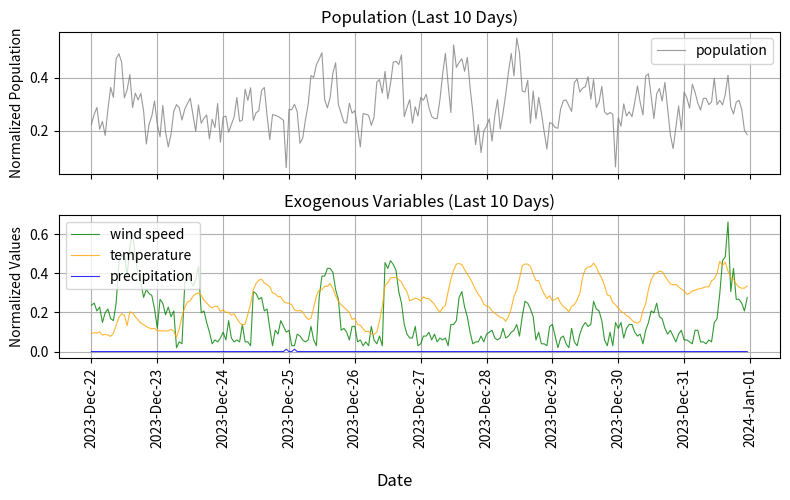

In [146]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 任意の期間設定（例: 最後のxx日間）
xx = 10
subset_start = -xx * 24  # xx日間分のデータ（時間単位で扱う場合）

# 2行1列のグラフを作成（任意の期間のみ表示）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=template1, sharex=True)

# アルファ値の設定
alpha = 0.8

### 上段：任意の期間（最後のxx日間）の人口データ
ax1.plot_date(timeLine[subset_start:], y_population_normalize[subset_start:], '-', label='population', color='gray', linewidth=0.8, alpha=alpha)
ax1.legend()
ax1.grid()
ax1.set_title(f'Population (Last {xx} Days)')
ax1.set_ylabel('Normalized Population')  # y軸のラベル

### 下段：任意の期間（最後のxx日間）の気象データ（風速、気温、降水量）
ax2.plot_date(timeLine[subset_start:], y_windspeed_normalize[subset_start:], '-', label='wind speed', color='green', linewidth=0.8, alpha=alpha)
ax2.plot_date(timeLine[subset_start:], y_temperature_normalize[subset_start:], '-', label='temperature', color='orange', linewidth=0.8, alpha=alpha)
ax2.plot_date(timeLine[subset_start:], y_precipitation_normalize[subset_start:], '-', label='precipitation', color='blue', linewidth=0.8, alpha=alpha)
ax2.legend()
ax2.grid()
ax2.set_title(f'Exogenous Variables (Last {xx} Days)')
ax2.set_ylabel('Normalized Values')

# 横軸の設定（期間のフォーマット）
locator = mdates.DayLocator(interval=1)  # 1日単位で表示
formatter = mdates.DateFormatter('%Y-%b-%d')  # 年-月-日形式で表示

# 日付のフォーマットを設定
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

# x軸のラベルを縦向きに回転
ax2.tick_params(axis='x', rotation=90)

# x軸のラベルを表示
fig.supxlabel('Date')

# レイアウトの調整
plt.tight_layout()
plt.show()

In [147]:
import pandas as pd

# DatetimeIndex をデータフレームに変換
df_timeLine = pd.DataFrame(timeLine)

# 他のデータをリセットインデックスで結合
df_pop_reset = df_pop[['population']].reset_index(drop=True)
df_weather_reset = df_weather[['prec', 'temp', 'wind']].reset_index(drop=True)
df_warnings_reset = df_warnings.reset_index(drop=True)

# 横方向に結合
df_ex = pd.concat([df_timeLine, df_pop_reset, df_weather_reset], axis=1)
df_ex = pd.concat([df_ex,df_warnings_reset], axis=1)

# 時系列をインデックスに設定
# df_ex
df_ex = df_ex.set_index('time')

print(df_ex)

                     population  prec  temp  wind  雷注意報  大雨注意報  洪水注意報  強風注意報  \
time                                                                           
2016-01-01 00:00:00         585   0.0   3.0   0.9   0.0    0.0    0.0   0.00   
2016-01-01 01:00:00         499   0.0   2.0   0.3   0.0    0.0    0.0   0.00   
2016-01-01 02:00:00         503   0.0   1.7   0.6   0.0    0.0    0.0   0.00   
2016-01-01 03:00:00         545   0.0   0.9   0.3   0.0    0.0    0.0   0.00   
2016-01-01 04:00:00         484   0.0   1.0   1.0   0.0    0.0    0.0   0.00   
...                         ...   ...   ...   ...   ...    ...    ...    ...   
2023-12-31 19:00:00         359   0.0   9.3   2.7   1.0    0.0    0.0   1.00   
2023-12-31 20:00:00         364   0.0   8.6   2.7   1.0    0.0    0.0   1.00   
2023-12-31 21:00:00         339   0.0   8.4   2.5   1.0    0.0    0.0   1.00   
2023-12-31 22:00:00         280   0.0   8.4   2.1   1.0    0.0    0.0   1.00   
2023-12-31 23:00:00         268   0.0   

# LSTM



In [148]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch

from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable



## Normalize dataframe values

In [149]:
# 日付を具体的に指定して分割する

# 指定した日付より前のデータを訓練用、以降のデータをテスト用とする
df_train = df_ex.loc[df_ex.index < train_end_date]
df_test = df_ex.loc[df_ex.index >= test_start_date]

df_test

,population,prec,temp,wind,雷注意報,大雨注意報,洪水注意報,強風注意報,大雨警報,洪水警報,暴風警報,大雨特別警報
time,,,,,,,,,,,,
2023-01-01 00:00:00,334,0.0,2.8,0.6,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,377,0.0,2.0,0.7,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,360,0.0,2.1,0.3,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,369,0.0,1.4,0.9,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,320,0.0,1.7,0.4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,359,0.0,9.3,2.7,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0
2023-12-31 20:00:00,364,0.0,8.6,2.7,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0
2023-12-31 21:00:00,339,0.0,8.4,2.5,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0


In [150]:
# 最大値と最小値を計算
max_value = np.max(df_test['population'])
min_value = np.min(df_test['population'])
diff_maxmin=max_value-min_value

max_value,min_value,diff_maxmin

(635, 156, 479)

In [151]:
import pandas as pd
import numpy as np

# 例: df_trainの作成

for name_var in df_train.columns:
    nan_locations = df_train[df_train[name_var].isna()]

    # NaNが見つかった場合のみ表示
    if not nan_locations.empty:
        print(f"{name_var} のNaNの場所と値:")
        print(nan_locations)
        print()

        # NaNを一つ前のデータで上書きする
        df_train.loc[:, name_var] = df_train[name_var].ffill()

# 最終的なDataFrameを表示
# print("上書き後のDataFrame:")
# print(df_train)

prec のNaNの場所と値:
                     population  prec  temp  wind  雷注意報  大雨注意報  洪水注意報  強風注意報  \
time                                                                           
2020-02-19 12:00:00         485   NaN   NaN   NaN   0.0    0.0    0.0    0.0   
2020-02-19 13:00:00         474   NaN   NaN   NaN   0.0    0.0    0.0    0.0   
2020-02-19 14:00:00         465   NaN   9.2   3.4   0.0    0.0    0.0    0.0   
2020-12-23 11:00:00         395   NaN   NaN   NaN   0.0    0.0    0.0    0.0   
2020-12-23 12:00:00         415   NaN   NaN   NaN   0.0    0.0    0.0    0.0   
2020-12-23 13:00:00         348   NaN  11.2   NaN   0.0    0.0    0.0    0.0   

                     大雨警報  洪水警報  暴風警報  大雨特別警報  
time                                           
2020-02-19 12:00:00   0.0   0.0   0.0     0.0  
2020-02-19 13:00:00   0.0   0.0   0.0     0.0  
2020-02-19 14:00:00   0.0   0.0   0.0     0.0  
2020-12-23 11:00:00   0.0   0.0   0.0     0.0  
2020-12-23 12:00:00   0.0   0.0   0.0     0.0  
2020-12

In [152]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

if exDataIsAll:
    df_train = scaler.fit_transform(df_train)
    df_test = scaler.fit_transform(df_test)
else:
    df_train = scaler.fit_transform(df_train[['population']])
    df_test = scaler.fit_transform(df_test[['population']])

# 特徴量の次元数を定義
n_dim = df_train.shape[1]  # 特徴量の数

In [153]:
df_test

array([[0.37160752, 0.        , 0.17293233, ..., 0.        , 0.        ,
        0.        ],
       [0.46137787, 0.        , 0.15288221, ..., 0.        , 0.        ,
        0.        ],
       [0.42588727, 0.        , 0.15538847, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.38204593, 0.        , 0.31328321, ..., 0.        , 0.        ,
        0.        ],
       [0.25887265, 0.        , 0.31328321, ..., 0.        , 0.        ,
        0.        ],
       [0.23382046, 0.        , 0.32581454, ..., 0.        , 0.        ,
        0.        ]])

In [154]:
df_test*diff_maxmin+min_value

array([[334.        , 156.        , 238.83458647, ..., 156.        ,
        156.        , 156.        ],
       [377.        , 156.        , 229.23057644, ..., 156.        ,
        156.        , 156.        ],
       [360.        , 156.        , 230.43107769, ..., 156.        ,
        156.        , 156.        ],
       ...,
       [339.        , 156.        , 306.06265664, ..., 156.        ,
        156.        , 156.        ],
       [280.        , 156.        , 306.06265664, ..., 156.        ,
        156.        , 156.        ],
       [268.        , 156.        , 312.06516291, ..., 156.        ,
        156.        , 156.        ]])

## Data slice


In [155]:

import numpy as np

window_size = 24  # ウィンドウサイズ（24時間）
forecast_steps = 24  # xx時間後を予測
n_data = len(df_ex) - window_size - forecast_steps + 1

# 訓練データとテストデータのサイズを変更
n_train = len(df_train) - window_size - forecast_steps + 1
n_test = len(df_test) - window_size - forecast_steps + 1

# 正解データを準備________________________________________
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i + window_size + forecast_steps - 1]  # 24時間後のデータを取得

# テストデータを準備______________________________________
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i + window_size + forecast_steps - 1]  # 24時間後のデータを取得

train_labels = train_labels[:, 0]  # 最初の列のみを使用

print(f'train:{train.shape}')
print(f'train_labels:{train_labels.shape}')
print()
print(test.shape)
print(f'test_labels:{test_labels.shape}')

train:(61321, 24, 12)
train_labels:(61321,)

(8713, 24, 12)
test_labels:(8713, 12)


### tips
 train_labelはtrain の最後の値よりも一つ先の値を取得していることに注意する．

    train[i] = df_train[i:i+window_size]
    # train[i]: [20 x 6] 
    # train[0]: df_train[0:20]のデータが入る.
    # ([0:20]は0から20個のデータ，つまりtrain[0]からtrain[19]まで)
**(df_train[0],df_train[1],df_train[2],...,df_train[18],df_train[19])**

    train_labels[i] = df_train[i+window_size]
    # train_labels[i]: [1 x 6] 
    # train_labels[0]: df_train[20]のデータが入る．
**(df_train[20])**






## Define LSTM model

In [156]:
# その他の必要なコード

train_torch = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train_torch, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [157]:
# # ##1層LSTM
# # 多変量を入力して、１変数の予測結果を返すLSTNモデル.
# class MyLSTM(nn.Module):
#     def __init__(self, feature_size, hidden_dim, n_layers):
#         super(MyLSTM, self).__init__()

#         self.feature_size = feature_size
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers
#         self.n_output = 1

#         self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, self.n_output)

#     def forward(self, x):
#         # hidden state
#         h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
#         # cell state
#         c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        
#         output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
#         hn = hn.view(-1, self.hidden_dim) 
#         y = self.fc(hn)
#         y = y.reshape(self.n_output, -1)

#         return y

In [158]:
import torch
import torch.nn as nn
from torch.autograd import Variable

##2層LSTM
class MyLSTM(nn.Module):


    def __init__(self, feature_size, hidden_dim, n_layers=2):  # デフォルトで2層
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        # 2層のLSTM
        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        # hidden state
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        # cell state
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        
        # LSTMの2層を通過
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # hnの形状を(batch_size, hidden_dim)に変換
        hn = hn[-1]  # 最終タイムステップの出力を使用

        # 全結合層を通して最終出力を取得
        y = self.fc(hn)

        # yの形状を(batch_size,)に整形
        y = y.squeeze()  # (batch_size,) にする

        return y

In [159]:

if exDataIsAll:
    feature_size  = 12
else:
    feature_size  = 1

n_hidden  = 64
n_layers  = 2

net = MyLSTM(feature_size, n_hidden, n_layers)

summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              53,248
├─Linear: 1-2                            65
Total params: 53,313
Trainable params: 53,313
Non-trainable params: 0

## Change epoch, Learning

In [160]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
    ## 最適化を図るための仕組みとして，Adamを使う．
loss_history = []
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
epochs = epochs

net.to(device)

MyLSTM(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [161]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x) 
        y = y.to('cpu')
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, ', Loss_Train:', tmp_loss)

Epoch: 0 , Loss_Train: 0.007936501924076717
Epoch: 1 , Loss_Train: 0.005759521569120498
Epoch: 2 , Loss_Train: 0.005648565780890016
Epoch: 3 , Loss_Train: 0.0055952787047739575
Epoch: 4 , Loss_Train: 0.005555618425677759
Epoch: 5 , Loss_Train: 0.00554172419389366
Epoch: 6 , Loss_Train: 0.005500266099993501
Epoch: 7 , Loss_Train: 0.005484116483407874
Epoch: 8 , Loss_Train: 0.005464321288850248
Epoch: 9 , Loss_Train: 0.005478258448875314
Epoch: 10 , Loss_Train: 0.005421273626398773
Epoch: 11 , Loss_Train: 0.005377745448113482
Epoch: 12 , Loss_Train: 0.005339937869943018
Epoch: 13 , Loss_Train: 0.005330596012097314
Epoch: 14 , Loss_Train: 0.005266161904766441
Epoch: 15 , Loss_Train: 0.0052614769586619295


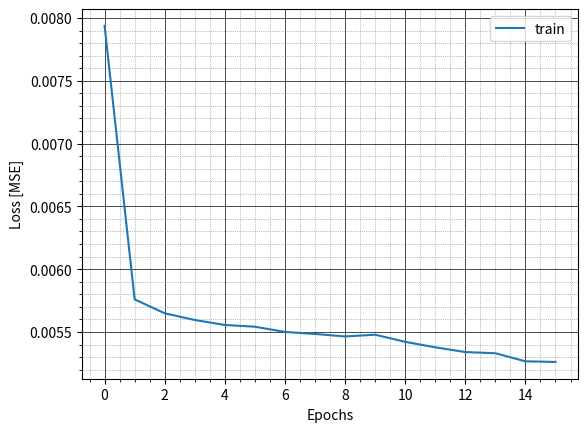

In [162]:
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss [MSE]")

# 主グリッドの設定
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# 補助グリッドの設定
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# # 横軸をtmpずつ表示させる設定
# tmp=20
# plt.xticks(range(0, len(loss_history) + 1, tmp))

graph_loss=f'{directory}result_{dir_str}_loss.png'
plt.savefig(graph_loss,dpi=300)
plt.show()

# Forecasting

**Train data でモデル性能をチェック**


In [163]:
# predicted_train_plot = []
# net.eval()

# for k in range(n_train):
#     x = train_torch[k].clone().detach()
#     x = x.reshape(1, window_size, feature_size)
#     x = x.to(device).float()
#     y = net(x)
#     y = y.to('cpu')
#     predicted_train_plot.append(y[0].item())

In [164]:
# fig, ax = plt.subplots(figsize=(30,8))

# plt.plot(range(len(df_train)), df_train[:, 0], label='Observed')
# plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Predicted')
# plt.legend()

# # 主グリッドの設定
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# # 補助グリッドの設定
# plt.minorticks_on()
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.title('Predicted population (Normalization)')
# plt.xlabel('data')
# plt.ylabel('population[standard]')
# plt.show()

**Test data でモデル性能をチェック**

以下，observed data を用いて予測をする場合

In [165]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_test_plot.append(y.item())  # y[0].item() を y.item() に変更

以下，predicted data を用いて予測をする場合

In [166]:
# # test data 50個目のデータ（下の正規化グラフの横軸50の箇所）からpredicted dataを用いる
# fake_point=100
# split_point=fake_point-window_size

# fake_test=test
# predicted_test_plot = []
# net.eval()

# for k in range(n_test):
#     # print(k)
#     if (k!=0):
#         for iii in range(k):
#             fake_test[k][23-iii,0]=predicted_test_plot[-iii]
#             if iii>23:
#                 break
#     if k>split_point:
#         x = torch.tensor(fake_test[k])
#     else:
#         x = torch.tensor(test[k])

#     x = x.reshape(1, window_size, feature_size)
#     x = x.to(device).float()
#     y = net(x)
#     y = y.to('cpu')
#     predicted_test_plot.append(y[0].item())
    

**正規化グラフ表示**

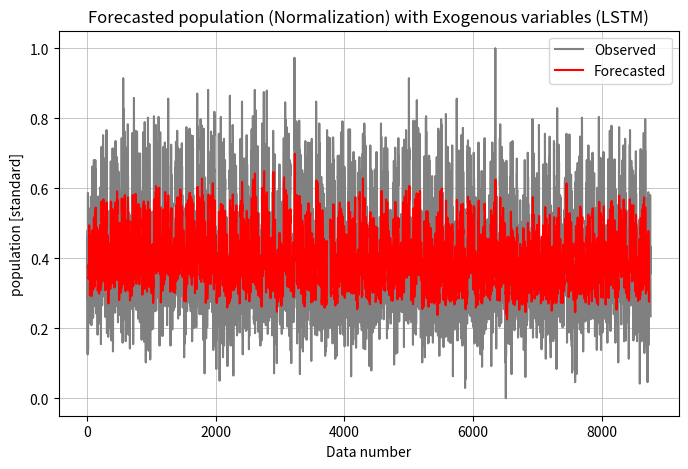

In [167]:
fig, ax = plt.subplots(figsize=template1)

plt.plot(range(len(df_test)), df_test[:, 0], label='Observed',color='gray')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Forecasted',color='red')
plt.legend()

# 主グリッドの設定
plt.grid(which='major', linestyle='-', linewidth='0.5')
if exDataIsAll:
    add_title_name  = ' with Exogenous variables'
else:
    add_title_name  = ' without exogenous variables'


plt.title('Forecasted population (Normalization)'+add_title_name+' (LSTM)')
plt.xlabel('Data number')
plt.ylabel('population [standard]')
plt.show()

正規化を戻す


In [168]:
#Observed
df_test_inversed = np.array(df_test[:,0]) * diff_maxmin + min_value

#Predicted
predicted_test_plot_inversed = np.array(predicted_test_plot) * diff_maxmin + min_value


データの加工

In [169]:

import pandas as pd

#Observed
df_test_inversed_plt = df_test_inversed # ndarray型なので，20個目から最後までの値が格納される

#Predicted
predicted_test_plot_inversed_plt = predicted_test_plot_inversed

# 日時データを生成します（1時間おきのデータを使用）
date_rng = pd.date_range(start=test_start_date, periods=len(df_test_inversed_plt), freq='h')
predicted_date_rng = date_rng[-len(predicted_test_plot_inversed_plt):]

グラフ表示

In [170]:
len(predicted_test_plot_inversed_plt)


8713

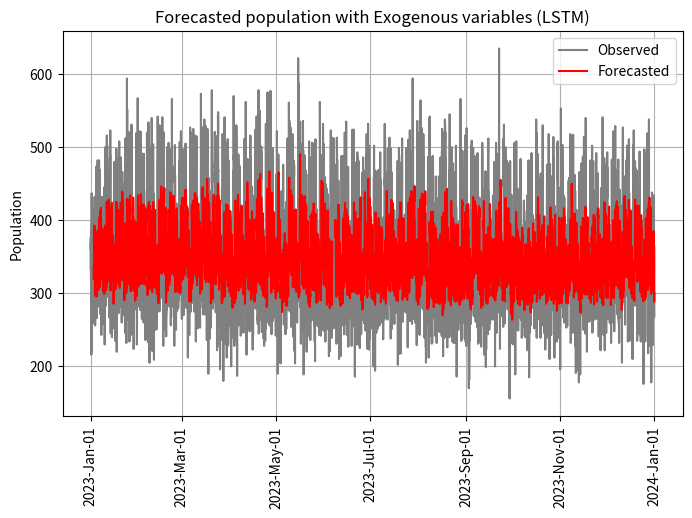

In [171]:
# プロット
fig, ax = plt.subplots(figsize=template1)  # サイズを指定する

# データのプロット
ax.plot(date_rng, df_test_inversed_plt, label='Observed', linewidth=1.5, color='gray')
ax.plot(predicted_date_rng, predicted_test_plot_inversed_plt, label='Forecasted', linewidth=1.5, color='red')
ax.legend()

# x軸のメジャーロケーターとフォーマッターの設定
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # 6時間ごと
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# マイナーグリッドを1時間ごとに設定
# ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # 1時間ごとのマイナーグリッド
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # マイナーグリッドのフォーマット

# メジャーグリッドを表示
ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle=':')

# 0度のラベルを削除し、90度回転したラベルを設定
# ax.tick_params(axis='x', rotation=90)  # 日付を90度回転

# x軸のラベルを明示的に設定（90度のラベルを表示）
xticks = ax.get_xticks()
ax.set_xticks(xticks)  # メジャーラベルだけを設定
ax.set_xticklabels([mdates.num2date(tick).strftime('%Y-%b-%d') for tick in xticks], rotation=90)

if exDataIsAll:
    add_title_name = ' with Exogenous variables'
else:
    add_title_name = ' without exogenous variables'

plt.title('Forecasted population' + add_title_name + ' (LSTM)')
# plt.xlabel('Date')
plt.ylabel('Population')
graph_forecast = f'{directory}result_{dir_str}_forecast.png'
plt.savefig(graph_forecast, dpi=300)

plt.show()

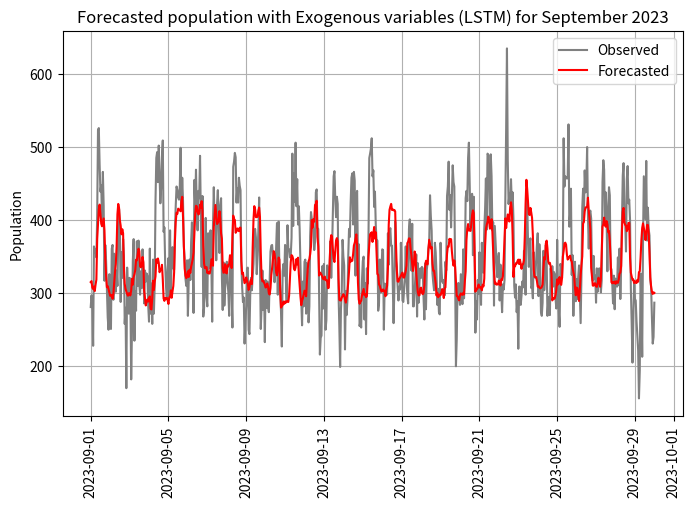

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 9月の範囲を設定（2023年の9月）
start_date = '2023-09-01'
end_date = '2023-09-30'

# 9月のデータにフィルタリング
mask_observed = (date_rng >= start_date) & (date_rng <= end_date)
filtered_observed = df_test_inversed_plt[mask_observed]

# 予測値のフィルタリング
# 予測値も、日付のフィルタリングを同様に行う
mask_predicted = (predicted_date_rng >= start_date) & (predicted_date_rng <= end_date)
filtered_predicted = predicted_test_plot_inversed_plt[mask_predicted]

# フィルタリングした日時データを取得
filtered_date_rng = date_rng[mask_observed]
filtered_predicted_date_rng = predicted_date_rng[mask_predicted]

# プロット
fig, ax = plt.subplots(figsize=template1)  # サイズを指定する

# データのプロット
ax.plot(filtered_date_rng, filtered_observed, label='Observed', linewidth=1.5, color='gray')
ax.plot(filtered_predicted_date_rng, filtered_predicted, label='Forecasted', linewidth=1.5, color='red')
ax.legend()

# x軸の設定
ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle=':')

# x軸のラベルを設定（90度のラベルを表示）
xticks = ax.get_xticks()
ax.set_xticks(xticks)  # メジャーラベルだけを設定
ax.set_xticklabels([mdates.num2date(tick).strftime('%Y-%m-%d') for tick in xticks], rotation=90)

if exDataIsAll:
    add_title_name = ' with Exogenous variables'
else:
    add_title_name = ' without exogenous variables'

plt.title('Forecasted population' + add_title_name + ' (LSTM) for September 2023')
plt.ylabel('Population')
graph_forecast_limited = f'{directory}result_{dir_str}_forecast_september_2023.png'
plt.savefig(graph_forecast_limited, dpi=300)

plt.show()

___

$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$

In [173]:
a=predicted_test_plot_inversed_plt[71:]
a

array([307.5859167 , 305.34095252, 304.67112631, ..., 291.69795078,
       297.31254536, 300.24303859])

In [174]:
import numpy as np

# NaNを0に置き換え
a = np.nan_to_num(a)

# 結果を表示
print(a)

[307.5859167  305.34095252 304.67112631 ... 291.69795078 297.31254536
 300.24303859]


In [175]:
# MAPEの計算
def calculate_mape(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100


# 後からpredictedの数だけ戻り，observedとpredictedを対応させる確認する．
mape = calculate_mape(df_test_inversed_plt[-len(a[71:]):], a[71:]) 
print(f'MAPE: {mape:.2f}%')

MAPE: 12.32%


___

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

In [176]:
import numpy as np

# MSEを計算する関数
def calculate_mse(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    return np.mean((true_values - predicted_values) ** 2)

# MSEの計算
mse = calculate_mse(df_test_inversed_plt[-len(predicted_test_plot_inversed_plt):], predicted_test_plot_inversed_plt)

print(f'MSE: {mse:.2f}')

MSE: nan


# Pickle 

In [177]:
import pickle
import os

# pickle #####################
# 保存する時間情報

### 保存したい複数の変数
# a = train_start_date
# b = train_end_date
# c = test_start_date
# d = test_end_date
# e = PATH_mesh
# f = window_size
# g = df_test
# h = predicted_test_plot
i = date_rng
j = df_test_inversed_plt
k = predicted_date_rng
l = predicted_test_plot_inversed_plt
# m = df_ex

### pickleで保存（書き出し）: 辞書にして複数の変数を保存
pickle_path = os.path.join(directory, f'vars_exo{exDataIsAll}.pickle')
with open(pickle_path, mode='wb') as fo:
    pickle.dump({
        # 'train_start_date': a, 
        # 'train_end_date': b, 
        # 'test_start_date': c, 
        # 'test_end_date': d, 
        'date_rng': i, 
        'df_test_inversed_plt': j, 
        'predicted_date_rng': k, 
        'predicted_test_plot_inversed_plt': l,
        # 'df_ex': m
    }, fo)

In [178]:
# 終了時刻を記録
end_time = datetime.datetime.now()

# 経過時間を計算（分単位）
elapsed_time = (end_time - start_time).total_seconds() / 60

# 結果を表示
print(f"Elapsed time: {elapsed_time:.2f} min")

Elapsed time: 2.04 min


In [179]:
import os

md_file_path = os.path.join(directory, f'report.md')
with open(md_file_path, 'w') as md_file:
    md_file.write(f"""
# Report for This LSTM model (Elapsed time: {elapsed_time:.2f} min)

File created time: {dir_str}

## Result 
<img src="{os.path.basename(graph_loss)}" width='600'/>
<img src="{os.path.basename(graph_forecast)}" width='600'/>
<img src="{os.path.basename(graph_forecast_limited)}" width='600'/>

- MAPE\t{mape:.1f}%
- MSE \t{mse:.2f}

## Pickle path
{pickle_path}

## Imput vars

### Exo data:
- {exDataIsAll}

### Exogenous data:
- {', '.join(df_ex.columns)}
 
### Period:
- train_start_date    = {train_start_date}
- train_end_date      = {train_end_date}
- test_start_date     = {test_start_date}  
- test_end_date       = {test_end_date}

### LSTM parameter
- window_size\t{window_size}
- epochs\t{epochs}
- ...
- feature_size\t{feature_size}
- n_hidden\t{n_hidden}
- n_layers\t{n_layers}
- net

     {net}


""")
    

In [180]:
import pandas as pd
import os 

# 変数の内容を定義

import numpy as np


# データの最初に空白を追加
empty_space = np.full((len(df_test_inversed_plt)-len(predicted_test_plot_inversed_plt),), np.nan)  # 空白の数を29に設定
predicted_test_plot_inversed_plt = np.concatenate((empty_space, predicted_test_plot_inversed_plt))

# データの形状を確認
print(predicted_test_plot_inversed_plt.shape)  # (8759,)


# データフレームを作成
data = {
    'datetime': date_rng,
    'df_test_inversed_plt': df_test_inversed_plt,
    'predicted_test_plot_inversed_plt': predicted_test_plot_inversed_plt
}

df = pd.DataFrame(data)

# CSVファイルに書き出し
# graph_loss=f'{directory}result_{dir_str}_loss.png'
csv_file_path =f'{directory}output_data.csv'  # 出力するCSVファイルのパス

df.to_csv(csv_file_path, index=False, encoding='utf-8')  # UTF-8でエンコード

(8760,)
